## Deep learning with Keras: Chest accelerometer data

Dataset from https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer

In [1]:
# Set a seed for reproducibility
import numpy as np
seed = 42
np.random.seed(seed)

## Problem 1: Identify person based on gait

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

C:\Users\jones\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Preparing the data

In [3]:
walking = np.load("walking_data.npy")

In [4]:
walking_labels = np.load("walking_labels.npy")

In [5]:
m = walking.shape[0]
from random import shuffle
indices = [x for x in range(m)]
shuffle(indices)
train_indices = indices[:int(m*0.6)]
val_indices = indices[int(m*0.6):int(m*0.8)]
test_indices = indices[int(m*0.8):]

In [7]:
X_train = walking[train_indices, :, :]
X_val = walking[val_indices, :, :]
X_test = walking[test_indices, :, :]

from keras.utils import to_categorical
# We have 15 integer labels, but these need to be one-hot encoded
# e.g. '4' becomes [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(walking_labels[train_indices])
y_val = to_categorical(walking_labels[val_indices])
y_test = to_categorical(walking_labels[test_indices])

In [8]:
print(X_train.shape)
print(y_train.shape)

(4075, 260, 3)
(4075, 15)


In [9]:
# Let's have a little look...
import matplotlib.pyplot as plt
%matplotlib inline

def plot_series(series):
    plt.plot(series[:, 0], color="red")
    plt.plot(series[:, 1], color="green")
    plt.plot(series[:, 2], color="blue")

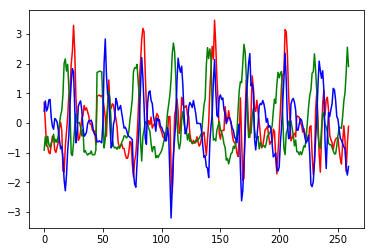

In [10]:
plot_series(X_train[0, :, :])

Can we tell between different people's data by eye?

Let's plot a few series for some different people - say, 5 series for 3 people.

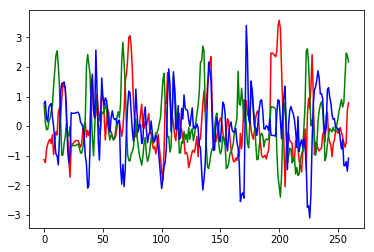

In [25]:
plot_series(X_train[4, :, :])

### The neural network

In [24]:
# Initiate the model - we'll use a sequential model so we can add to it
model = Sequential()

# Start with a convolutional layer:
#  * filters: The number of "features" we want to learn; number of patterns to try to identify
#  * kernel_size: The "window" to consider, i.e. we look at a rolling window captuiring [kernel_size] time points at once
#  * strides: How many time steps to "roll forward" each time we move the window
#  * activation: The activation function to use; convolutional layers typically use REctified Linear Unit function
#  * input_shape: We're feeding in observations each of shape 260{time points}*3{directional acceleration features}
model.add(Conv1D(filters=40, kernel_size=40, strides=2, activation="relu", input_shape=(260, 3)))
print(model.output_shape)

model.add(MaxPooling1D(pool_size=2))

# Another convolutional layer: this one finds "meta-patterns" in the patterns the first layer picked up
model.add(Conv1D(filters=40, kernel_size=5, activation="relu"))
print(model.output_shape)

# If the net is too large and computation too slow, we can reduce the number of parameters with max pooling
# This layer would reduce the number of parameters by half by combining ("pooling") parameters
# i.e. parameters get paired up (by position) and the maximum one only is kept
model.add(MaxPooling1D(pool_size=2))
print(model.output_shape)

# We still have a 3-dimensional set of parameters - we need to make this 2-dimensional, so we "flatten"
# (Unstack all the leaves and lay them out next to each other)
model.add(Flatten())
print(model.output_shape)

# We need to finish with a couple of dense layers: one to detect relationships between the (flattened)
# convolutional neurons, and...
model.add(Dense(100, activation="sigmoid"))
print(model.output_shape)

# ... one to present the output as a one-hot vector.
# (We typically use softmax in the very final layer since it provides a "stronger" signal than sigmoid)
model.add(Dense(15, activation="softmax"))
print(model.output_shape)

(None, 111, 40)
(None, 51, 40)
(None, 25, 40)
(None, 1000)
(None, 100)
(None, 15)


In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 111, 40)           4840      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 55, 40)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 51, 40)            8040      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 25, 40)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               100100    
_________________________________________________________________
dense_6 (Dense)              (None, 15)                1515      
Total para

In [26]:
# We have to compile the network before we can run it, defining:
# * Loss function to use (always categorical cross-entropy for multi-class logistic regression)
# * Optimizer to use
#   ("adam" = "ADAptive Movement estimation", but e.g. "sgd" = "Stochastic Gradient Descent" will work, just slower)
# * Metrics to report (NOT used for adjusting parameters - that's what the loss function is for!)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
# Fit it!
# * X_train and y_train are training data/labels
# * epochs: How many times to pass the training data through and update the network's parameters
# * batch_size: How many observations to include in each batch the optimizer sees
# * Also show us the accuracy for the cross-validation set
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_val, y_val))

Train on 4075 samples, validate on 1358 samples
Epoch 1/10
4075/4075 [==============================] - 4s 995us/step - loss: 2.3329 - acc: 0.3072 - val_loss: 1.6711 - val_acc: 0.5655
Epoch 2/10
4075/4075 [==============================] - 3s 717us/step - loss: 1.1706 - acc: 0.7151 - val_loss: 0.8533 - val_acc: 0.8056
Epoch 3/10
4075/4075 [==============================] - 3s 744us/step - loss: 0.7077 - acc: 0.8356 - val_loss: 0.6105 - val_acc: 0.8726
Epoch 4/10
4075/4075 [==============================] - 3s 757us/step - loss: 0.5206 - acc: 0.8746 - val_loss: 0.4784 - val_acc: 0.8925
Epoch 5/10
4075/4075 [==============================] - 3s 740us/step - loss: 0.4139 - acc: 0.9028 - val_loss: 0.4085 - val_acc: 0.8925
Epoch 6/10
4075/4075 [==============================] - 3s 737us/step - loss: 0.3277 - acc: 0.9296 - val_loss: 0.3475 - val_acc: 0.9205
Epoch 7/10
4075/4075 [==============================] - 3s 750us/step - loss: 0.2626 - acc: 0.9490 - val_loss: 0.3107 - val_acc: 0.9278


At this point we could try to improve that cross-validation accuracy score, e.g. change network structure.

### Reporting

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
y_pred = model.predict_classes(X_test)
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

             precision    recall  f1-score   support

          0       0.98      0.97      0.98       110
          1       0.95      0.87      0.91        94
          2       0.98      0.82      0.89        76
          3       0.96      0.98      0.97       102
          4       0.94      0.92      0.93        66
          5       0.94      0.98      0.96       128
          6       0.87      0.81      0.84        64
          7       0.83      0.92      0.87        74
          8       0.94      0.94      0.94        97
          9       0.96      0.94      0.95        87
         10       0.94      0.99      0.96        95
         11       0.89      0.88      0.89        84
         12       0.96      0.98      0.97       104
         13       0.85      0.94      0.89        84
         14       0.95      0.94      0.94        94

avg / total       0.93      0.93      0.93      1359

[[107   0   0   1   0   0   2   0   0   0   0   0   0   0   0]
 [  1  82   0   1   0   0   0   3

---

## Visualising features

We can try to visualise the "features" of the time series which the convolutional layers of the net have learned to identify.

In [30]:
# Get the values from each layer
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'conv1d_5': <keras.layers.convolutional.Conv1D at 0x1a490148978>,
 'conv1d_6': <keras.layers.convolutional.Conv1D at 0x1a490148d30>,
 'dense_5': <keras.layers.core.Dense at 0x1a493a12c18>,
 'dense_6': <keras.layers.core.Dense at 0x1a493716828>,
 'flatten_3': <keras.layers.core.Flatten at 0x1a4936f8ef0>,
 'max_pooling1d_4': <keras.layers.pooling.MaxPooling1D at 0x1a4900218d0>,
 'max_pooling1d_5': <keras.layers.pooling.MaxPooling1D at 0x1a4901489e8>}

In [31]:
# Plot the weights from a given layer
def plot_filter(layer, k):
    x = layer_dict[layer].get_weights()[0][:, :, k]
    plt.plot(x[:, 0], color="red")
    plt.plot(x[:, 1], color="green")
    plt.plot(x[:, 2], color="blue")

In [32]:
plot_filter("conv1d_1", 9)

KeyError: 'conv1d_1'

We can also see if there are any patterns in the autocorrelation plots which might suggest strong periodicity.

In [23]:
def plot_filter_corr(layer, k):
    x = layer_dict[layer].get_weights()[0][:, :, k]
    t0 = np.correlate(x[:, 0], x[:, 0], mode="full")
    t1 = np.correlate(x[:, 1], x[:, 1], mode="full")
    t2 = np.correlate(x[:, 2], x[:, 2], mode="full")
    plt.plot(t0[int(len(t0)/2):], color="red")
    plt.plot(t1[int(len(t1)/2):], color="green")
    plt.plot(t2[int(len(t2)/2):], color="blue")

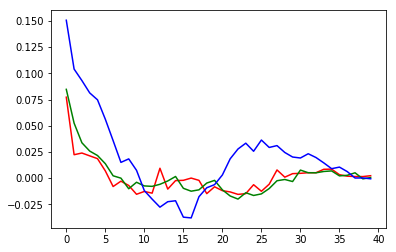

In [24]:
plot_filter_corr("conv1d_1", 9)

Let's plot each filter with its autocorrelation plot.

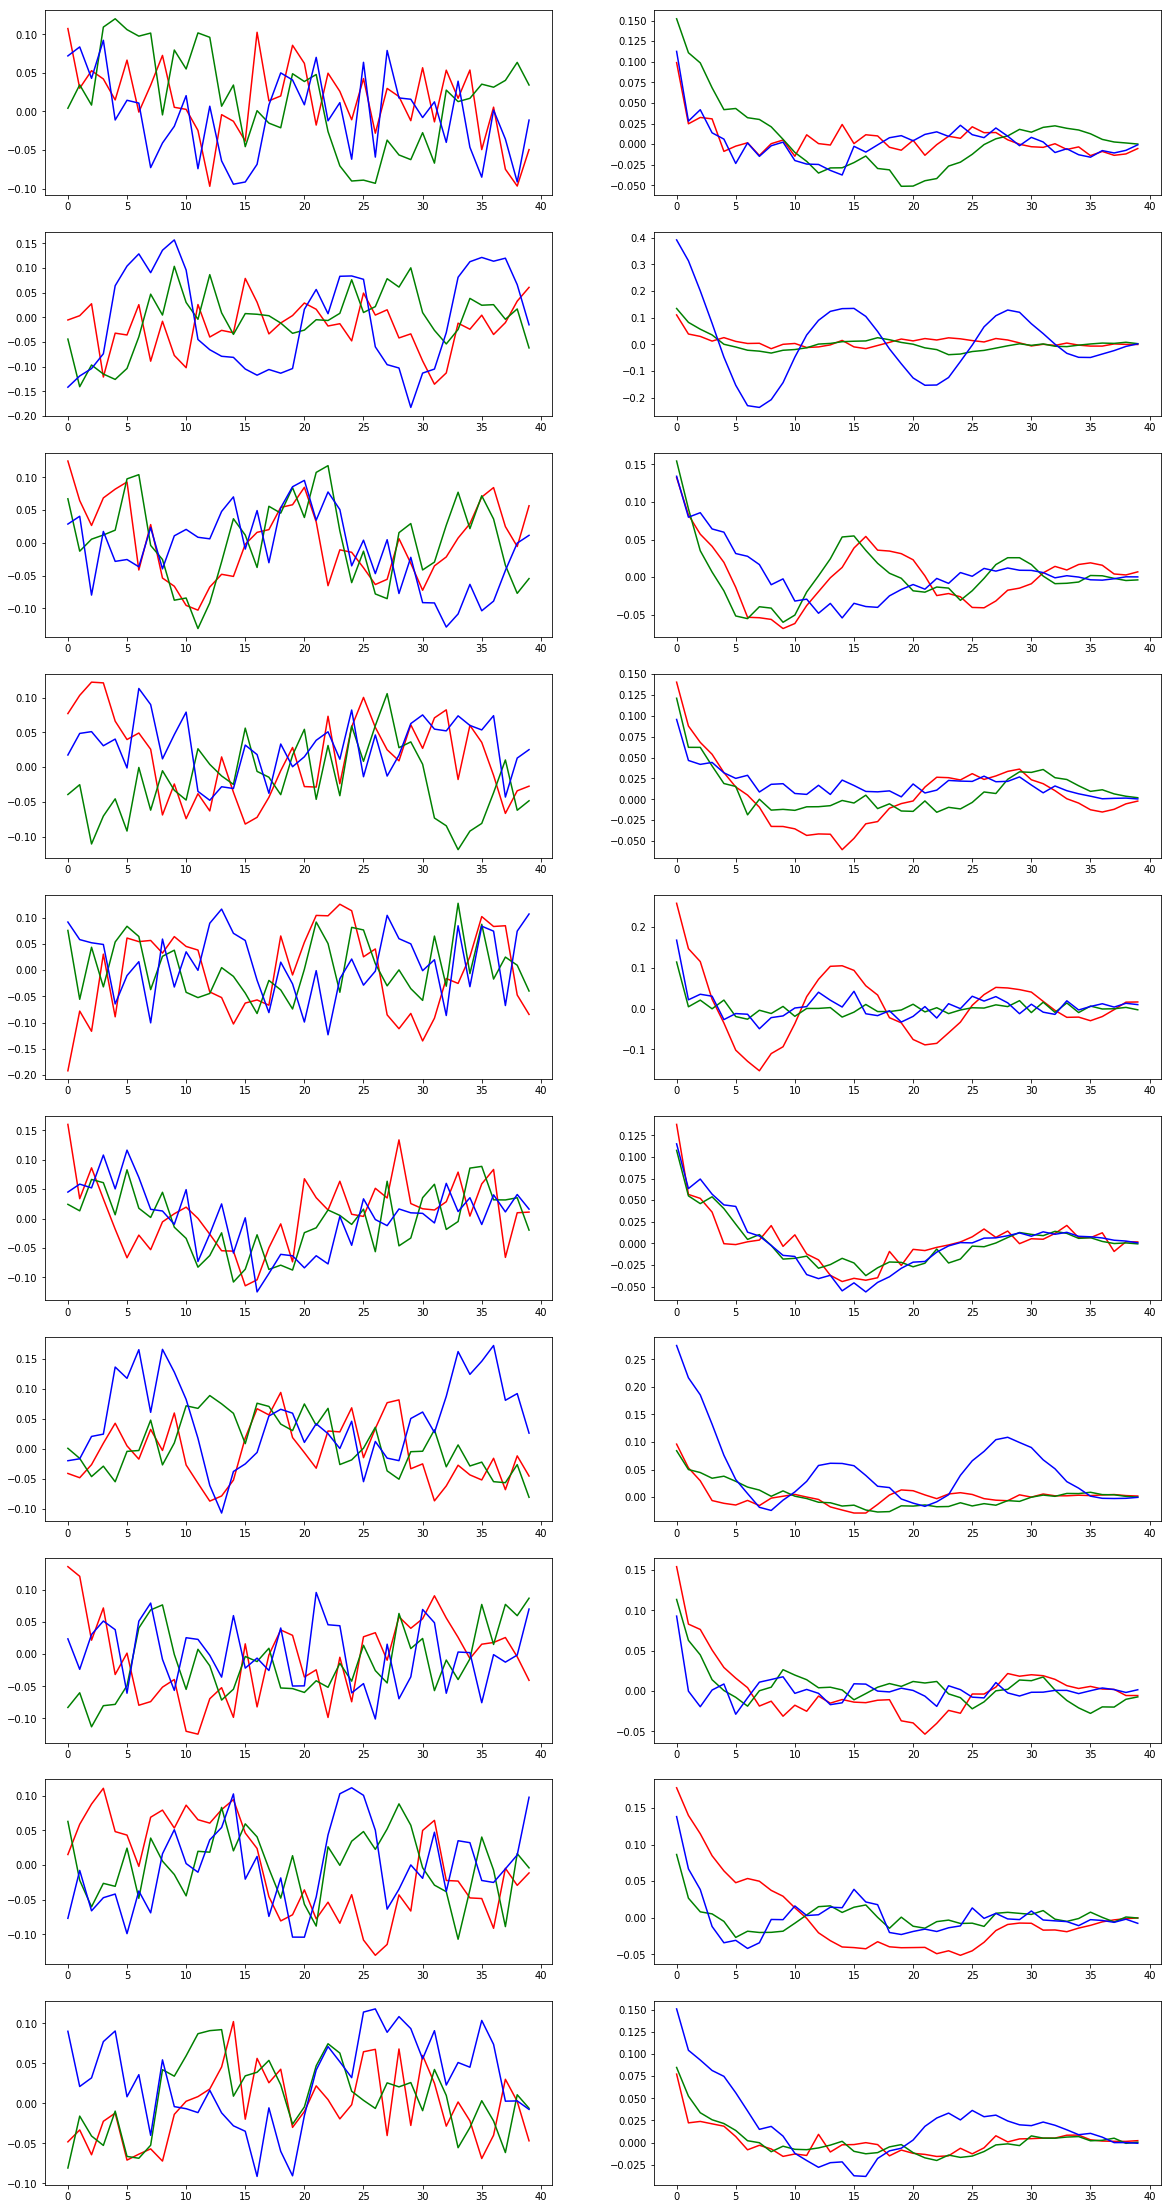

In [25]:
ax, fig = plt.subplots(ncols=2, nrows=10, figsize=(20, 40))

for k in range(10):
    plt.subplot(10, 2, 2*k + 1)
    plot_filter("conv1d_1", k)
    plt.subplot(10, 2, 2*k + 2)
    plot_filter_corr("conv1d_1", k)

---

## Repurposing a previously-trained model

If we take off the final fully-connected layers of the network, we can train a new network making use of the convolutional features we've already learned.

In [26]:
# "Walking" corresponds to activity label 4
climbing = chopped[(chopped[:, 0, 3] == 5), :, :]

In [27]:
m2 = climbing.shape[0]
from random import shuffle
indices = [x for x in range(m2)]
shuffle(indices)
train2_indices = indices[:int(m2*0.6)]
val2_indices = indices[int(m2*0.6):int(m2*0.8)]
test2_indices = indices[int(m2*0.8):]

In [28]:
m2

915

In [29]:
from sklearn.preprocessing import scale
from keras.utils import to_categorical

# Time series data is in layers 0 to 2
# Neural nets need scaled and ideally 0-centred data
X2_train = np.apply_along_axis(scale, 1, climbing[train2_indices, :, 0:3])
X2_val = np.apply_along_axis(scale, 1, climbing[val2_indices, :, 0:3])
X2_test = np.apply_along_axis(scale, 1, climbing[test2_indices, :, 0:3])

# Person labels are in layer 4
# We have 15 integer labels, but these need to be one-hot encoded
# e.g. '4' becomes [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y2_train = to_categorical(climbing[train2_indices, 0, 4])
y2_val = to_categorical(climbing[val2_indices, 0, 4])
y2_test = to_categorical(climbing[test2_indices, 0, 4])

In [30]:
X2_train.shape

(549, 260, 3)

In [31]:
from keras.models import clone_model

In [32]:
model2 = keras.models.clone_model(model)
model2.set_weights(model.get_weights())

In [33]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 40)           4840      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 102, 40)           16040     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51, 40)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2040)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204100    
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1515      
Total params: 226,495
Trainable params: 226,495
Non-trainable params: 0
_________________________________________________________________


In [34]:
model2.pop()
model2.pop()

In [35]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 111, 40)           4840      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 102, 40)           16040     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51, 40)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2040)              0         
Total params: 20,880
Trainable params: 20,880
Non-trainable params: 0
_________________________________________________________________


In [36]:
for layer in model2.layers:
    layer.trainable = False

In [37]:
model2.add(Dense(100, activation="sigmoid"))
model2.add(Dense(15, activation="softmax"))

In [38]:
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [39]:
model2.fit(X2_train, y2_train, epochs=10, batch_size=100, validation_data=(X2_val, y2_val))

Train on 549 samples, validate on 183 samples
Epoch 1/10
549/549 [==============================] - 1s 2ms/step - loss: 2.7195 - acc: 0.1403 - val_loss: 2.4960 - val_acc: 0.1967
Epoch 2/10
549/549 [==============================] - 0s 735us/step - loss: 2.1941 - acc: 0.3716 - val_loss: 2.2356 - val_acc: 0.3279
Epoch 3/10
549/549 [==============================] - 0s 763us/step - loss: 1.8455 - acc: 0.5592 - val_loss: 2.1075 - val_acc: 0.3333
Epoch 4/10
549/549 [==============================] - 0s 755us/step - loss: 1.5981 - acc: 0.6521 - val_loss: 1.9633 - val_acc: 0.3661
Epoch 5/10
549/549 [==============================] - 0s 752us/step - loss: 1.4082 - acc: 0.7505 - val_loss: 1.8840 - val_acc: 0.3661
Epoch 6/10
549/549 [==============================] - 0s 764us/step - loss: 1.2448 - acc: 0.8069 - val_loss: 1.8578 - val_acc: 0.4098
Epoch 7/10
549/549 [==============================] - 0s 715us/step - loss: 1.1127 - acc: 0.8525 - val_loss: 1.7735 - val_acc: 0.3661
Epoch 8/10
549/549

In [40]:
y2_pred = model.predict_classes(X2_test)
print(classification_report(np.argmax(y2_test, axis=1), y2_pred))
print(confusion_matrix(np.argmax(y2_test, axis=1), y2_pred))

             precision    recall  f1-score   support

          0       0.40      0.20      0.27        10
          1       1.00      0.38      0.56        13
          2       0.78      0.70      0.74        10
          3       0.41      0.50      0.45        18
          4       0.56      0.38      0.45        13
          5       0.14      0.22      0.17         9
          6       0.59      0.93      0.72        14
          7       0.50      0.43      0.46        21
          8       0.00      0.00      0.00         8
          9       0.38      0.50      0.43        12
         10       0.65      1.00      0.79        11
         11       0.14      0.07      0.10        14
         12       0.83      0.83      0.83         6
         13       0.27      0.21      0.24        14
         14       0.17      0.30      0.21        10

avg / total       0.46      0.44      0.43       183

[[ 2  0  0  1  0  0  2  0  0  0  5  0  0  0  0]
 [ 0  5  0  0  0  1  0  3  0  0  0  0  0  1  3]
